In [1]:
import os
import dotenv
dotenv.load_dotenv(".env")
from huggingface_hub import Repository, HfApi
from huggingface_hub import upload_folder

from huggingface_hub import login
login(token=os.getenv("HF_TOKEN"))

from utils import *
from data_utils import *
from visualization_utils import *
import os.path as osp
from transformers import logging
from hparam_tuning import *

logging.set_verbosity_warning()


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Data
The dataset is comprised of raw English-language tweets annotated with six emotion classes.

## Cleaning
The texts in the dataset contains multiple types of noise:
- Duplicated samples - There are a couple of dozens duplicated examples with different labels in the training set
- HTML artifacts and metadata - The tweets were probably scraped directly from the website, resulting in HTML tags that are embedded into the texts
- Missing apostrophes - The data was probably normalized, replacing apostrophes with whita space. The result is "t"s and "s"s and other characters scattered around the texts.
- Slang - As customed in user produced texts in social media, the text contains heavy useage of shorthand text and slang words.
- Character repetition - The text also contains words with duplicated characters


In [2]:
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")

def apply_ds_clean(fn, **fn_kwargs):
    """Applies some cleaning function fn to the dataset and flags the changed rows for visualization"""
    def apply(dataset):
        text = dataset["text"]
        cleaned = fn(text, **fn_kwargs)
        return {"cleaned": cleaned,
                "is_cleaned": cleaned!= text}
    return apply

### Duplicates handling
We show 5 examples of duplicated examples with their labels. We decided to remove these examples from the dataset completely to reduces misclassification between the already closely related labels.

In [3]:
show_duplicates(dataset)

    Labels      |                                     Tweet                                      
--------------------------------------------------------------------------------------------------
(Joy/Love)      | i am not amazing or great at photography but i feel passionate about it
(Love/Joy)      | i began to feel accepted by gaia on her own terms
(Fear/Anger)    | i bet taylor swift basks in the knowledge that the boys she writes songs about probably feel tortured
(Love/Joy)      | i cant escape the tears of sadness and just true grief i feel at the loss of my sweet friend and sister
(Fear/Surprise) | i could feel myself hit this strange foggy wall


### HTML Metadata Cleaning
We employ a context-aware sliding window approach to remove HTML tags, metadata attributes, and technical noise from web-scraped text. The method uses a designated library for initial tag removal, followed by a configurable sliding window algorithm that identifies and removes sequences of technical terms while preserving legitimate words that appear in isolation, ensuring minimal loss of meaningful content.<br>
We show 5 examples. The first row in each case is the original example with the HTML metadata that was found in red. The second row is the cleaned sample.

In [4]:
dataset_cleaned = dataset.map(apply_ds_clean(clean_html_metadata, window_size=5, threshold=0.35))
show_diff(dataset_cleaned, n_cases=5, fname="html_cleaning.txt")

1) i feel over the moon when the guy i liked started a class cbc read more href http jazzyboy
   i feel over the moon when the guy i liked started a class cbc read more
2) i feel completely submitted and devoted to a href http www
   i feel completely submitted and devoted to
3) i feel that karma punished me because i don t know the meaning of contentment img src http www
   i feel that karma punished me because i don t know the meaning of contentment
4) i feel so very loved by a href http www
   i feel so very loved by
5) i wake up feeling dazed from deep slumber and convoluted sometimes exhausting dreams a bit like a href http skdd
   i wake up feeling dazed from deep slumber and convoluted sometimes exhausting dreams a bit like


### Fixing Missing Apostrophes
USing pattern matching we trace the stray characters and fix the the contraction.<br>
We show 5 examples. The first row is the original example with the corrupted contraction colored red. The second row is the fixed contraction colored green.

In [5]:
dataset_cleaned = dataset.map(apply_ds_clean(fix_missing_apostrophes))
show_diff(dataset_cleaned, n_cases=5,fname="fixed_apos.txt")

1) i left malaysia feeling pleased that i d finished my first full race and excited about what we achieved on sunday at sepang
   i left malaysia feeling pleased that i'd finished my first full race and excited about what we achieved on sunday at sepang
2) i just ran by feel and i m glad i didn t look because i probably would have freaked out which happened a little later on in the race
   i just ran by feel and i'm glad i didn't look because i probably would have freaked out which happened a little later on in the race
3) i think they ll be sexy but will also make me feel more confident than the teeny tiny itsy bitsy bottoms that seem to be in vogue
   i think they'll be sexy but will also make me feel more confident than the teeny tiny itsy bitsy bottoms that seem to be in vogue
4) i m tryin my level best be a gud pal but i cant help if u dont understad what i feel abt u dats ur problemn i don think carin for sum is a crime img src rte emoticons smile sarcastic
   i'm tryin my level 

### Normalizing Slang
We utilize a dictionary of common slang words and shorthand writings to normalize slang words and replace abbreviations.<br>
We show 5 examples. The first row of each examples is the original sample with the slang/abbreviation colored red. The second row shows the normalized samples with the correction colored green.

In [6]:
dataset_cleaned = dataset.map(apply_ds_clean(normalize_slang_text))
show_diff(dataset_cleaned, n_cases=5, fname="slang_norm.txt")


1) i feel so strange and sick i have to wake up in three hours seems like everything runs in threes now days t r e e s
   i feel so strange and sick i have to wake up in three hours seems like everything runs in threes now days t are e e s
2) i was aware of feeling so surprised so disappointed i don t think i ever really thought i d have to have a c section
   i was aware of feeling so surprised so disappointed i don t think i ever really thought i d have to have a see section
3) i love the snow lol it just makes everything feel so tranquil
   i love the snow laughing out loud it just makes everything feel so tranquil
4) im starting to not buy the whole everything happens for a reason bit or god has a plan b c i feel that god is love and theres no way that he would torture me and other women like weve been tortured dealing w fertility issues
   im starting to not buy the whole everything happens for a reason bit or god has a plan because i feel that god is love and theres no way that h

### Normalizing Contractions
After fixing the missing apostrophese and normalizing the slang we also expand all the contractions using a built in python library.<br>
We show 5 examples. The first row show the original sample and the second row shows the normalized example with the expanded contraction in green. 

In [7]:
dataset_cleaned = dataset.map(apply_ds_clean(fix_contructions))
show_diff(dataset_cleaned, n_cases=5, fname="contructions.txt")

1) im well chuffed made me feel fab straight away
   i am well chuffed made me feel fab straight away
2) im feeling groggy and having a bad skin day
   i am feeling groggy and having a bad skin day
3) i guess fiction powers along on good emotions versus bad emotions there wouldnt be much excitement if all the feelings between the characters were sweet and harmonious
   i guess fiction powers along on good emotions versus bad emotions there would not be much excitement if all the feelings between the characters were sweet and harmonious
4) i cant be a counselor for you in the way i feel i should i am too damaged myself
   i cannot be a counselor for you in the way i feel i should i am too damaged myself
5) im feeling pretty hopeful this morning that we are going to get this right
   i am feeling pretty hopeful this morning that we are going to get this right


### Normalizing Repeated Characters
We identify all character repetitions of more the 2 times and replace them with dual repetitions. <br>
We show 5 examples. The first row shows the original sample with the word with character repetition in red. The second row show the normalized sample with the fixed repetition in green.

In [8]:
dataset_cleaned = dataset.map(apply_ds_clean(normalize_repeated_chars))
show_diff(dataset_cleaned, n_cases=5, fname="rep_chars.txt")

1) i shall just sleep feeling pissed psssh
   i shall just sleep feeling pissed pssh
2) i feel so honoured to receive this from krista know to the blogger world as a href https www
   i feel so honoured to receive this from krista know to the blogger world as a href https ww
3) i feel so clever recent comments a href http www
   i feel so clever recent comments a href http ww
4) i still did not really feel like myself and i kind of hated these pictures but i am soooo glad we took them
   i still did not really feel like myself and i kind of hated these pictures but i am soo glad we took them
5) i am feeling hmmmmm melancholy
   i am feeling hmm melancholy


### Overall Cleaning
The following show samples before and after they were processed with the entire cleaning pipeline

In [9]:
dataset_cleaned = dataset.map(apply_ds_clean(clean_sample))
show_diff(dataset_cleaned, n_cases=5, fname="total.txt")

1) i feel very distressed because i m supportive of this campaign and with the senator jackson told cnn
   i feel very distressed because i am supportive of this campaign and with the senator jackson told cnn
2) i know i did and im still feeling the effects of rich dinners and sweet treats
   i know i did and i am still feeling the effects of rich dinners and sweet treats
3) im feeling horrible
   i am feeling horrible
4) im happy i got her to see her smile and laugh yesterday something to bring me joy when i feel completely drained
   i am happy i got her to see her smile and laugh yesterday something to bring me joy when i feel completely drained
5) i didnt feel brave or confident coming out of the mass
   i did not feel brave or confident coming out of the mass


## Class and Lenght Distributions
The dataset is highly unbalanced with class labels Joy and Sandness hold 60% of the samples and Surprise less than 5%.<br>
The samples have a mean length of about 2 tokens with a tail that reaches to 70 tokens. There are no samples that reach the maximum input length of the BERT variants.

### Stratification
A random 20% subset of the training data is reserved for validation. The validation is was stratified jointly by class label frequency and sample length. Length stratification was performed by partitioning the token lengths into deciles, which werethen combined with the corresponding class labels to form the stratification criterion.

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15938 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/12750 [00:00<?, ? examples/s]

Map:   0%|          | 0/3188 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

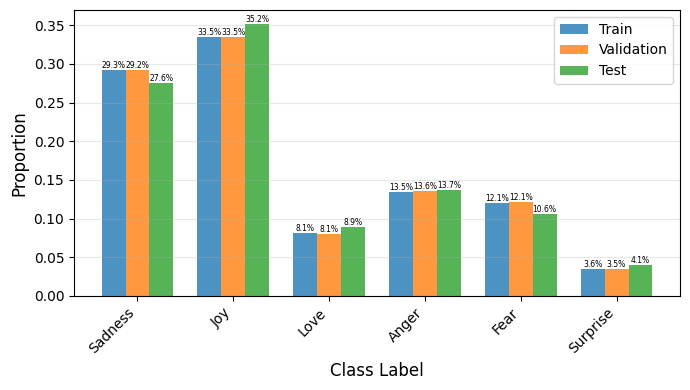

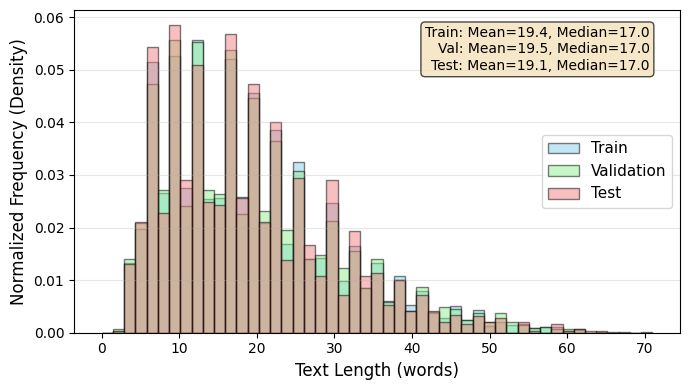

In [10]:
dataset = preprocess(dataset, load_hf_classifier("google/electra-small-discriminator", 6, False)[-1])
plot_class_distribution(dataset, fname="plots/class_dist_w_val")
plot_length_distribution(dataset, fname="plots/len_dist_w_val")

# Models
## Model Types

In this work we experiment with 3 model types of different sizes:
- RoBERTa (base, large)
- ELECTRA (small, base, large)
- DeBERTa (base)

In [11]:
model_names = [
         "google/electra-small-discriminator",
         "google/electra-base-discriminator",
         "FacebookAI/roberta-base",
         "microsoft/deberta-base",
         "FacebookAI/roberta-large",
         "google/electra-large-discriminator",
]
trained_models = [
                 "nisimachluf/electra-small-tweet-classification",
                 "nisimachluf/electra-base-tweet-classification",
                 "nisimachluf/roberta-base-tweet-classification",
                 "nisimachluf/deberta-base-tweet-classification",
                 "nisimachluf/roberta-large-tweet-classification",
                 "nisimachluf/electra-large-tweet-classification",
]
ckpt_dir = "ckpts"

## Hyperparameters Tuning
We run hyperparameter tuning for the follwoing hyperparameters:
- Learning Rate in 1e-5 - 7e-5
- Num Training Epochs in 10 - 20
- Warmup Ratio in 0.01 - 0.1
- Waight Decay in 0.002 - 0.025


In [12]:
for model_name in model_names:
    dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")    
    tune_hyperparams(model_name=model_name, dataset=dataset, weighted=True)

Found tuned hyperparameters for google/electra-small-discriminator at hparams/google/electra-small-discriminator.json
Found tuned hyperparameters for google/electra-base-discriminator at hparams/google/electra-base-discriminator.json
Found tuned hyperparameters for FacebookAI/roberta-base at hparams/FacebookAI/roberta-base.json
Found tuned hyperparameters for microsoft/deberta-base at hparams/microsoft/deberta-base.json
Found tuned hyperparameters for FacebookAI/roberta-large at hparams/FacebookAI/roberta-large.json
Found tuned hyperparameters for google/electra-large-discriminator at hparams/google/electra-large-discriminator.json


## Training
We train the models using the tuned hyperparameters. We use warmup phase to prevent the corruption of the pretrained weights, early stopping and weights regularization to avoid overfitting.<br>
To account for the class imbalance we train with a weighted BCE. The weights are inverse to the class count, normalized by the most frequent class count.

In [13]:
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")
for model_name, trained_model in zip(model_names, trained_models):
    if model_exists_on_hub(trained_model):
        print("Found finetuned model for {} on the hub ({})".format(osp.basename(model_name), trained_model))
    else:
        hparams = load_hparams(model_name) #{"learning_rate": 2.0586645480619823e-05, "num_train_epochs": 12, "warmup_ratio": 0.03347555147148858, "weight_decay": 0.0148288265589339}
        train(model_name, dataset, ckpt_dir, batch_size=32, log_results=True, trained_weights_dir="trained_weights_newst", **hparams)
    
        # push model to hub
        local_model_path = os.path.join("trained_weights", model_name)
        upload_folder(
            folder_path=local_model_path,
            repo_id=trained_model,
            repo_type="model",
            ignore_patterns=["*.pyc", "__pycache__"]
        )

Found finetuned model for electra-small-discriminator on the hub (nisimachluf/electra-small-tweet-classification)
Found finetuned model for electra-base-discriminator on the hub (nisimachluf/electra-base-tweet-classification)
Found finetuned model for roberta-base on the hub (nisimachluf/roberta-base-tweet-classification)
Found finetuned model for deberta-base on the hub (nisimachluf/deberta-base-tweet-classification)
Found finetuned model for roberta-large on the hub (nisimachluf/roberta-large-tweet-classification)
Found finetuned model for electra-large-discriminator on the hub (nisimachluf/electra-large-tweet-classification)


## Compression

In [14]:
import zipfile
import os.path as osp
from transformers import logging, get_linear_schedule_with_warmup
from hparam_tuning import *
from data_utils import *
import torch
import copy
import os
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import DataCollatorWithPadding
from utils import *
import pandas as pd
from IPython.display import display
from visualization_utils import *
import dotenv
from huggingface_hub import Repository, HfApi
from huggingface_hub import upload_folder

In [15]:
hf_username = "nisimachluf" 
base_project = "electra-base-compressed"

model_suffixes = [
    "single-step-hybrid",
    "single-step-pruning",
    "single-step-ST",
    "iterative-approach-pruning",
    "iterative-approach-hybrid"
]

paths = [
    "./single_step/hybrid_model",
    "./single_step/pruning_model",
    "./single_step/ST_model",
    "./iterative/with_ce", 
    "./iterative/with_hybrid"
]

full_repo_ids = []

# 3. Execution Loop
for path, suffix in zip(paths, model_suffixes):
    # Construct the full repo ID (e.g., Yahav/electra-base-compressed-single-step-hybrid)
    full_repo_ids.append(f"{hf_username}/{base_project}-{suffix}")

In [16]:
for repo_id in full_repo_ids:
    if model_exists_on_hub(repo_id):
        print(f"Found finetuned model for {repo_id}")

Found finetuned model for nisimachluf/electra-base-compressed-single-step-hybrid
Found finetuned model for nisimachluf/electra-base-compressed-single-step-pruning
Found finetuned model for nisimachluf/electra-base-compressed-single-step-ST
Found finetuned model for nisimachluf/electra-base-compressed-iterative-approach-pruning
Found finetuned model for nisimachluf/electra-base-compressed-iterative-approach-hybrid


In [19]:
model_name = "nisimachluf/electra-base-tweet-classification"
keep_cols = ["input_ids", "token_type_ids", "attention_mask", "label"]
model, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")
preprocessed_dataset = preprocess(dataset, tokenizer)
processed_dataset = DatasetDict({
        split: ds.remove_columns([c for c in ds.column_names if c not in keep_cols])
        for split, ds in preprocessed_dataset.items()})
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15938 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/15938 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15938 [00:00<?, ? examples/s]

Map:   0%|          | 0/12750 [00:00<?, ? examples/s]

Map:   0%|          | 0/3188 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

### Compression Methods

### Single step

#### Pruning

In [20]:
repo_id = full_repo_ids[1]
if not model_exists_on_hub(repo_id):
    teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
    student = initialize_student(teacher, mode="pruning", num_layers=6)
    print("Teacher params:", count_parameters(teacher)[0])
    print("Student params:", count_parameters(student)[0])
    trainer = CompressionTrainer(
        loss_name="ce",
        teacher=teacher,
        student=student,
        dataset=processed_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        weights = calc_class_weights(processed_dataset['train']),
        path="./single_step/pruning_model"
    )
    trainer.inialize_training()
    trainer.train_model()

#### Distiliation (Student Teacher)

In [21]:
repo_id = full_repo_ids[2]
if not model_exists_on_hub(repo_id):
    teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
    student = initialize_student(teacher, mode="st", num_layers=6)
    print("Teacher params:", count_parameters(teacher)[0])
    print("Student params:", count_parameters(student)[0])

    trainer = CompressionTrainer(
        loss_name="kd",
        teacher=teacher,
        student=student,
        dataset=processed_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        weights = calc_class_weights(processed_dataset['train']),
        path="./single_step/ST_model"
    )
    trainer.inialize_training()
    trainer.train_model()

#### Hybrid

In [22]:
repo_id = full_repo_ids[0]
if not model_exists_on_hub(repo_id):
    teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
    student = initialize_student(teacher, mode="pruning", num_layers=6)
    print("Teacher params:", count_parameters(teacher)[0])
    print("Student params:", count_parameters(student)[0])
    trainer = CompressionTrainer(
        loss_name="hybrid",
        teacher=teacher,
        student=student,
        dataset=processed_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        weights = calc_class_weights(processed_dataset['train']),
        path="./single_step/hybrid_model"
    )
    trainer.inialize_training()
    trainer.train_model()

In [25]:
full_repo_ids

['nisimachluf/electra-base-compressed-single-step-hybrid',
 'nisimachluf/electra-base-compressed-single-step-pruning',
 'nisimachluf/electra-base-compressed-single-step-ST',
 'nisimachluf/electra-base-compressed-iterative-approach-pruning',
 'nisimachluf/electra-base-compressed-iterative-approach-hybrid']

In [28]:
def predict_on_dataset(model_path, dataset, split='test', batch_size=32, device=None, cache_file='predictions.json', name_extension_len=2):
    """
    Load a model and make predictions on a dataset split.
    
    Args:
        model_path: Path to the saved model directory
        dataset: HuggingFace Dataset or DatasetDict
        split: Name of the split to predict on (default: 'test')
        batch_size: Batch size for inference (default: 32)
        device: Device to use ('cuda' or 'cpu'). If None, auto-detects.
        cache_file: Path to JSON file for caching results (default: 'predictions.json')
    
    Returns:
        dict: Dictionary containing:
            - 'predictions': list of predicted class indices
            - 'labels': list of true labels (if available)
            - 'metrics': dict with accuracy, recall, precision, f1 scores (if labels available)
            - 'total_time': total inference time in seconds
            - 'time_per_sample_mean': mean time per sample in seconds
            - 'time_per_sample_std': std deviation of time per sample in seconds
    """
    import time
    from tqdm import tqdm
    
    # Extract model name from path for caching
    if name_extension_len > 0:
        model_name = "-".join(model_path.split('/')[-1].split("-")[:name_extension_len])
    else:
        model_name = model_path.split('/')[-1]
    cache_key = f"{model_name}"
    
    # Check if results are already cached (skip if cache_file is None)
    if cache_file and os.path.exists(cache_file):
        with open(cache_file, 'r') as f:
            cache = json.load(f)
        if cache_key in cache and split in cache[cache_key]:
            print(f"Loading cached results for {cache_key} on {split} split")
            return cache[cache_key][split]
    else:
        cache = {}
    
    # Auto-detect device if not specified
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load model and tokenizer
    print(f"Loading model: {cache_key}")
    model, tokenizer = load_hf_classifier(model_path, n_classes=6, training=False)
    model.to(device)
    
    # Get the dataset split
    if isinstance(dataset, DatasetDict):
        data = dataset[split]
    else:
        data = dataset
    data = data.map(clean_text)
    
    # Prepare for inference
    all_predictions = []
    all_probabilities = []
    all_labels = []
    sample_times = []
    
    # Track inference time
    start_time = time.time()
    
    # Process in batches with progress bar
    num_batches = (len(data) + batch_size - 1) // batch_size
    for i in tqdm(range(0, len(data), batch_size), total=num_batches, desc="Inference"):
        batch_end = min(i + batch_size, len(data))
        batch_texts = data['text'][i:batch_end]
        batch_size_actual = batch_end - i
        
        # Tokenize batch with padding to longest in batch
        tokenized = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors='pt'
        )
        
        # Move inputs to device
        inputs = {k: v.to(device) for k, v in tokenized.items()}
        
        # Get predictions - time only the model inference
        with torch.no_grad():
            batch_start_time = time.time()
            outputs = model(**inputs)
            batch_time = time.time() - batch_start_time
            
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)
        
        all_predictions.extend(preds.cpu().numpy().tolist())
        all_probabilities.extend(probs.cpu().numpy())
        
        # Collect labels if available
        if 'label' in data.features:
            all_labels.extend(data['label'][i:batch_end])
        
        # Track time per sample in this batch
        sample_times.extend([batch_time / batch_size_actual] * batch_size_actual)
    
    # Calculate total time and time per sample statistics
    total_time = time.time() - start_time
    time_per_sample_mean = np.mean(sample_times)
    time_per_sample_std = np.std(sample_times)
    
    result = {
        'predictions': all_predictions,
        'total_time': total_time,
        'time_per_sample_mean': time_per_sample_mean,
        'time_per_sample_std': time_per_sample_std
    }
    
    if all_labels:
        result['labels'] = all_labels
        
        # Calculate metrics if labels are available
        compute_metrics = get_metrics_fn()
        metrics = compute_metrics((np.array(all_probabilities), np.array(all_labels)))
        result['metrics'] = metrics
    
    # Save to cache with compact format for lists (skip if cache_file is None)
    if cache_file:
        print(f"Saving results to {cache_file}")
        if cache_key not in cache:
            cache[cache_key] = {}
        cache[cache_key][split] = result
        cache_dir = osp.dirname(cache_file)
        if cache_dir:
            os.makedirs(cache_dir, exist_ok=True)
        with open(cache_file, 'w') as f:
            json.dump(cache, f, indent=2, separators=(',', ': '))
        
        # Rewrite with compact lists
        with open(cache_file, 'r') as f:
            content = f.read()
        
        # Replace multiline lists with single-line compact format
        import re
        content = re.sub(
            r'"(predictions|labels)":\s*\[\s*((?:\d+,?\s*)+)\]',
            lambda m: f'"{m.group(1)}": [{", ".join(m.group(2).replace(",", "").split())}]',
            content,
            flags=re.MULTILINE | re.DOTALL
        )
        
        with open(cache_file, 'w') as f:
            f.write(content)
    
    return result

#### Results

In [29]:
pruning_results = predict_on_dataset(full_repo_ids[1], preprocessed_dataset, cache_file="cached_results/compressed_predictions.json", name_extension_len=-1)
st_results = predict_on_dataset(full_repo_ids[2], preprocessed_dataset, cache_file="cached_results/compressed_predictions.json", name_extension_len=-1)
hybrid_results = predict_on_dataset(full_repo_ids[0], preprocessed_dataset, cache_file="cached_results/compressed_predictions.json", name_extension_len=-1)
origin_results = predict_on_dataset(model_name, preprocessed_dataset, cache_file="cached_results/compressed_predictions.json", name_extension_len=-1)

df = pd.DataFrame.from_dict(
    {
        "full model": {
            **origin_results["metrics"],
            "sample run time": origin_results["time_per_sample_mean"],
            "sample rum std" : origin_results["time_per_sample_std"],
        },
        "pruning": {
            **pruning_results["metrics"],
            "sample run time": pruning_results["time_per_sample_mean"],
            "sample rum std" : pruning_results["time_per_sample_std"],
        },
        "st": {
            **st_results["metrics"],
            "sample run time": st_results["time_per_sample_mean"],
            "sample rum std" : st_results["time_per_sample_std"]
        },
        "hybrid": {
            **hybrid_results["metrics"],
            "sample run time": hybrid_results["time_per_sample_mean"],
            "sample rum std" : hybrid_results["time_per_sample_std"]
        },
    },
    orient="index"
)


print("\n")
display(df)

Loading model: electra-base-compressed-single-step-pruning


Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 44.78it/s]


Saving results to cached_results/compressed_predictions.json
Loading model: electra-base-compressed-single-step-ST


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 44.93it/s]


Saving results to cached_results/compressed_predictions.json
Loading model: electra-base-compressed-single-step-hybrid


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 47.20it/s]


Saving results to cached_results/compressed_predictions.json
Loading model: electra-base-tweet-classification


Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 31.63it/s]


Saving results to cached_results/compressed_predictions.json




,accuracy,recall,precision,f1,sample run time,sample rum std
full model,0.940882,0.945751,0.898813,0.918409,0.000553,0.000106
pruning,0.934369,0.912175,0.910474,0.910981,0.000320,0.000083
st,0.925852,0.911155,0.888791,0.898876,0.000316,0.000075
hybrid,0.932365,0.919749,0.898746,0.908595,0.000303,0.000079


### Iterative Approach

In [30]:
layers_to_drop = [11, 9, 7, 5, 3, 1]  # alternating top layers

#### Pruning

In [32]:
repo_id = full_repo_ids[3]
if not model_exists_on_hub(repo_id):
    first_teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
    final_student_folder = iterative_with_trainer(first_teacher, processed_dataset, tokenizer,
                                                    layers_to_drop, "ce", data_collator, save_dir="itertive")


#### Hybrid

In [33]:
repo_id = full_repo_ids[4]
if not model_exists_on_hub(repo_id):
    first_teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
    final_student_folder = iterative_with_trainer(first_teacher, processed_dataset, tokenizer,
                                                    layers_to_drop, "hybrid", data_collator, save_dir="iterative")


#### Results

In [34]:
pruning_results = predict_on_dataset(full_repo_ids[3], preprocessed_dataset, cache_file="cached_results/compressed_predictions.json", name_extension_len=-1)
hybrid_results = predict_on_dataset(full_repo_ids[4], preprocessed_dataset, cache_file="cached_results/compressed_predictions.json", name_extension_len=-1)
origin_results = predict_on_dataset(model_name, preprocessed_dataset, cache_file="cached_results/compressed_predictions.json", name_extension_len=-1)

df = pd.DataFrame.from_dict(
    {
        "full model": {
            **origin_results["metrics"],
            "sample run time": origin_results["time_per_sample_mean"],
            "sample rum std" : origin_results["time_per_sample_std"],
        },
        "pruning": {
            **pruning_results["metrics"],
            "sample run time": pruning_results["time_per_sample_mean"],
            "sample rum std" : pruning_results["time_per_sample_std"],
        },
        "hybrid": {
            **hybrid_results["metrics"],
            "sample run time": hybrid_results["time_per_sample_mean"],
            "sample rum std" : hybrid_results["time_per_sample_std"]
        },
    },
    orient="index"

    
)
print("\n")
display(df)

Loading model: electra-base-compressed-iterative-approach-pruning


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 46.90it/s]


Saving results to cached_results/compressed_predictions.json
Loading model: electra-base-compressed-iterative-approach-hybrid


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 45.77it/s]


Saving results to cached_results/compressed_predictions.json
Loading cached results for electra-base-tweet-classification on test split




,accuracy,recall,precision,f1,sample run time,sample rum std
full model,0.940882,0.945751,0.898813,0.918409,0.000553,0.000106
pruning,0.935371,0.917540,0.905589,0.911128,0.000301,0.000088
hybrid,0.932365,0.916705,0.897515,0.905255,0.000310,0.000062


#### Push to huggingface

In [36]:
from huggingface_hub import create_repo, upload_folder, login

def push_results_to_hub(local_dir, repo_name):
    """
    Creates the repo if it doesn't exist and uploads the model folder.
    """
    abs_local_path = os.path.abspath(local_dir)
    
    if not os.path.exists(abs_local_path):
        print(f"Skipping: {abs_local_path} does not exist.")
        return

    print(f"Ensuring repo exists: {repo_name}")
    
    # Create the repo (exist_ok=True prevents errors if it already exists)
    create_repo(repo_id=repo_name, exist_ok=True, repo_type="model")

    print(f"Pushing files from {abs_local_path} to {repo_name}...")
    upload_folder(
        folder_path=abs_local_path,
        repo_id=repo_name,
        commit_message=f"Upload compressed ELECTRA model: {os.path.basename(local_dir)}",
        repo_type="model",
        ignore_patterns=["*.pyc", "__pycache__", ".git*"]
    )
    print(f"Successfully pushed to: https://huggingface.co/{repo_name}\n")

# 2. Define your paths and names
# Your Hugging Face username (as seen in your 'Yahav/' namespace)
hf_username = "nisimachluf" 
base_project = "electra-base-compressed"

model_suffixes = [
    "single-step-hybrid",
    "single-step-pruning",
    "single-step-ST",
    "iterative-approach-pruning",
    "iterative-approach-hybrid"
]

paths = [
    "./single_step/hybrid_model",
    "./single_step/pruning_model",
    "./single_step/ST_model",
    "./itertive/with_ce", 
    "./iterative/with_hybrid"
]

# 3. Execution Loop
for path, suffix in zip(paths, model_suffixes):
    # Construct the full repo ID (e.g., Yahav/electra-base-compressed-single-step-hybrid)
    full_repo_id = f"{hf_username}/{base_project}-{suffix}"
    if not model_exists_on_hub(full_repo_id):
        push_results_to_hub(path, full_repo_id)

## Evaluation
We evaluate the models on the training set using the same cleaning procedure.<br>
We measure the common metrics for classification: Acccuracy, Recall, Precision and F1. Except for Accuracy, the metrics are calculated per class. We use macro averaging to calculate global metrics.
<br>
Interesting observations:
- ELECTRA-large outperforms all other models in terms of F1. This is due to its large number of parameters.
- On the other hand ReBERTa-large which has a similar number of parameters is outperformed by the base models. Is it overfit?
- DeBERTa is the slowest of all models, althogh having less Trasformer layers/parameters than large models. We attribute it to the disentangled attention mechanism.
- Electra-base and RoBERTa-base having approximately the same number of parameters and the same number of layers but RoBERTa-base is more than 10% faster. We believe this is coming from the difference in vocabulay size. RoBERTa's vocabulary is much larger, and therefore it processes less tokens compared to ELECTRA-base
- The differences between the base and large models are negligible probably because the dataset is not large and the task is simple.

In [37]:
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")
for trained_model in trained_models:
    results = predict_on_dataset(trained_model, dataset, cache_file="cached_results/predictions.json")
display_results()

Loading cached results for electra-small on test split
Loading cached results for electra-base on test split
Loading cached results for roberta-base on test split
Loading cached results for deberta-base on test split
Loading cached results for roberta-large on test split
Loading cached results for electra-large on test split


,Model,Accuracy,Recall,Precision,F1 Score,Inference Time (ms)
0,ELECTRA-large,0.9395,0.942767,0.900827,0.918277,1.048807
1,DeBERTa-base,0.9380,0.929684,0.909360,0.918121,1.185395
2,ELECTRA-base,0.9405,0.945393,0.897881,0.917703,0.574193
3,RoBERTa-base,0.9395,0.929204,0.903191,0.914190,0.496531
4,RoBERTa-large,0.9340,0.916800,0.899077,0.907449,0.907432
5,ELECTRA-small,0.9285,0.902224,0.903099,0.902552,0.568530


### Confusion Matrices
The confusion matrices reveal a more detailed view about the models' perfomance.<br>
Most of the models performed well on the most frequent classes (Joy and Sadness). Most of the confusions were between the pairs Love-Joy and Fear-Surprise.<br>
Specifically, we see that the ELECTRA-large and ELECTRA-base models excelled on the rare classes. This is interesting because in contrast to RoBERTa and DeBERTa, they were trained with a different pretrain task. This might have resulted in more reacher features. In addition, 

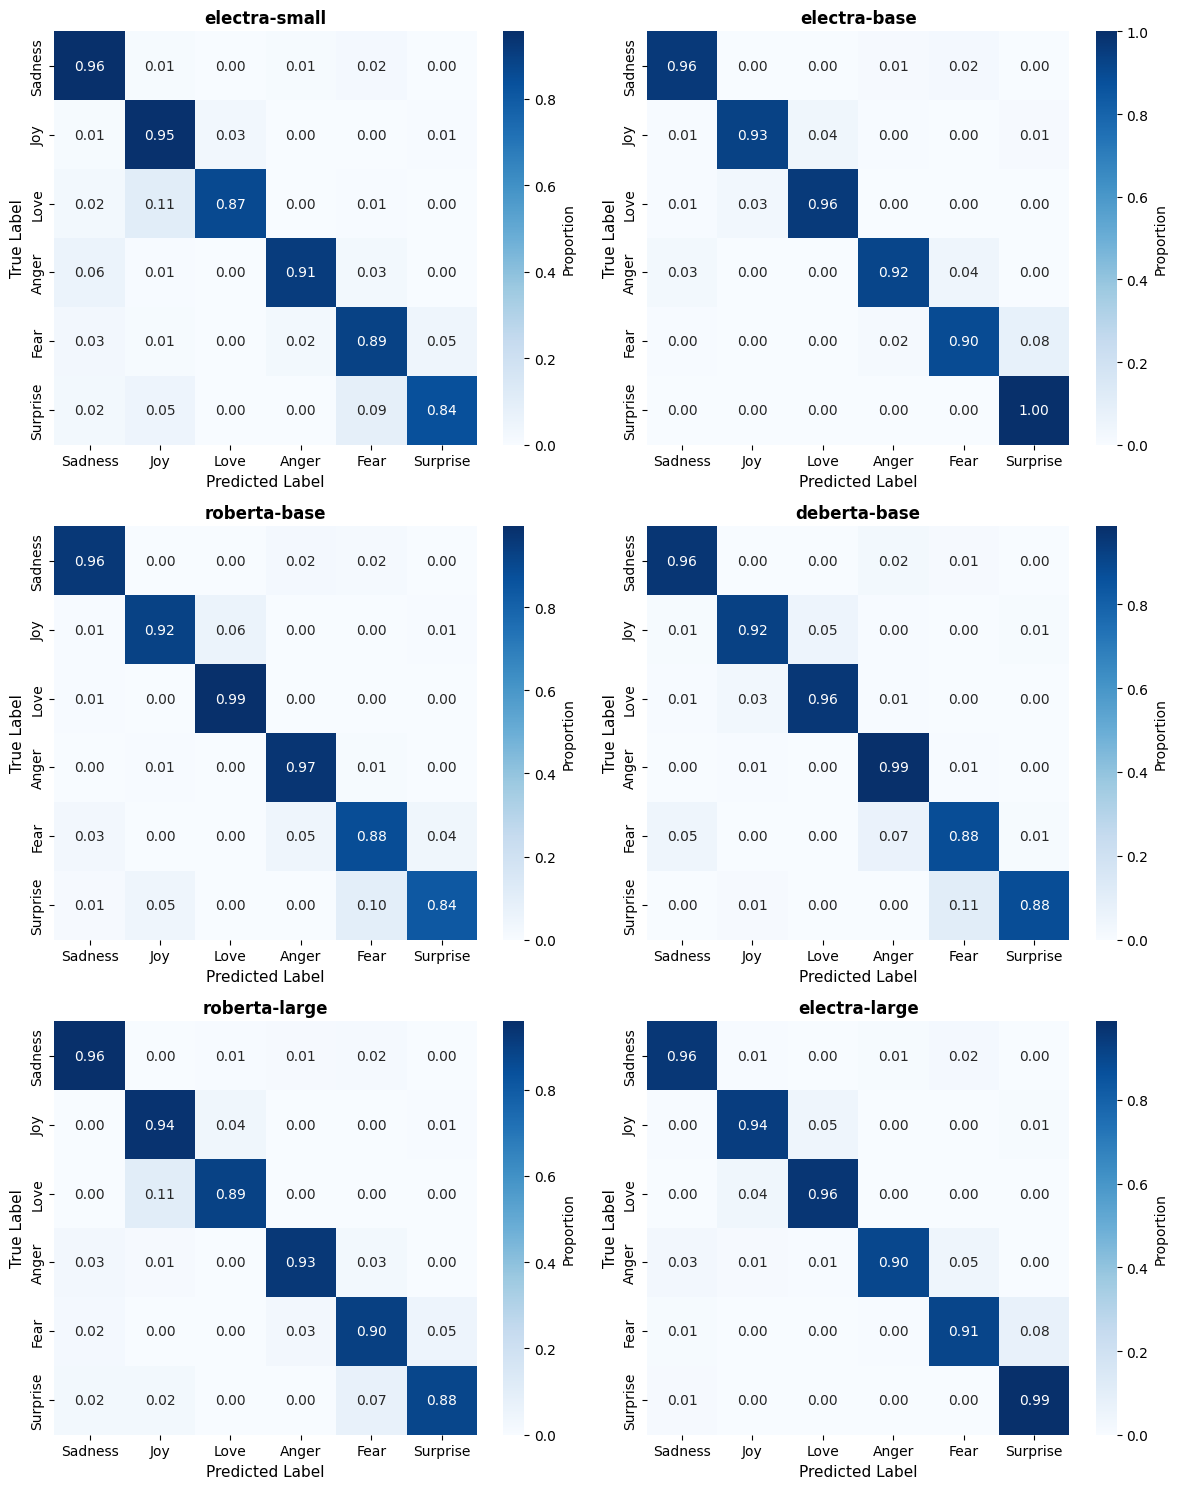

In [38]:
plot_confusion_matrices(predictions_cache_path="cached_results/predictions.json", fname="plots/confusion_matrices", selected_model="electra-base", selected_model_fpath="plots/confusion_matrix_electra-base")

### Feature Seperation
In addition to the classic classification metrics, we also measure the models' ability to seperate samples from different classes.<br>
We extract features for each sample, use TSNE to project them to two dimensions and KMeans to cluster the results to 6 classes.<br>
Then we apply Adjusted Rand Index (ARI) and Adjusted Mutual Information (AMI) to measure the how well the clusters capture the classes.<br>
<br>
On the left side plots, we see that the pretrained weights are indistingishable in terms of class seperability.
On the right side plots we see the clustered projected samples color coded by the class. All the models separate the classes very nicely. The more frequent classes exhibit more cohesive clusters compared to the lesser frequent classes which sometime results in 2 disjoint clusters. Some small clusters are comprised of samples of different classes, and are probably the source for the recal/precision degredation. The classes resulted from RoBERTa more sparse compared to the clusters of ELECTRA and DeBERTa. We find it hard to explain

Loading cached TSNE features for electra-small (pretrained)
Loading cached metrics for electra-small (pretrained)
Loading cached TSNE features for electra-small (finetuned)
Loading cached metrics for electra-small (finetuned)
Loading cached TSNE features for electra-base (pretrained)
Loading cached metrics for electra-base (pretrained)
Loading cached TSNE features for electra-base (finetuned)
Loading cached metrics for electra-base (finetuned)
Loading cached TSNE features for roberta-base (pretrained)
Loading cached metrics for roberta-base (pretrained)
Loading cached TSNE features for roberta-base (finetuned)
Loading cached metrics for roberta-base (finetuned)
Loading cached TSNE features for deberta-base (pretrained)
Loading cached metrics for deberta-base (pretrained)
Loading cached TSNE features for deberta-base (finetuned)
Loading cached metrics for deberta-base (finetuned)
Loading cached TSNE features for roberta-large (pretrained)
Loading cached metrics for roberta-large (pretra

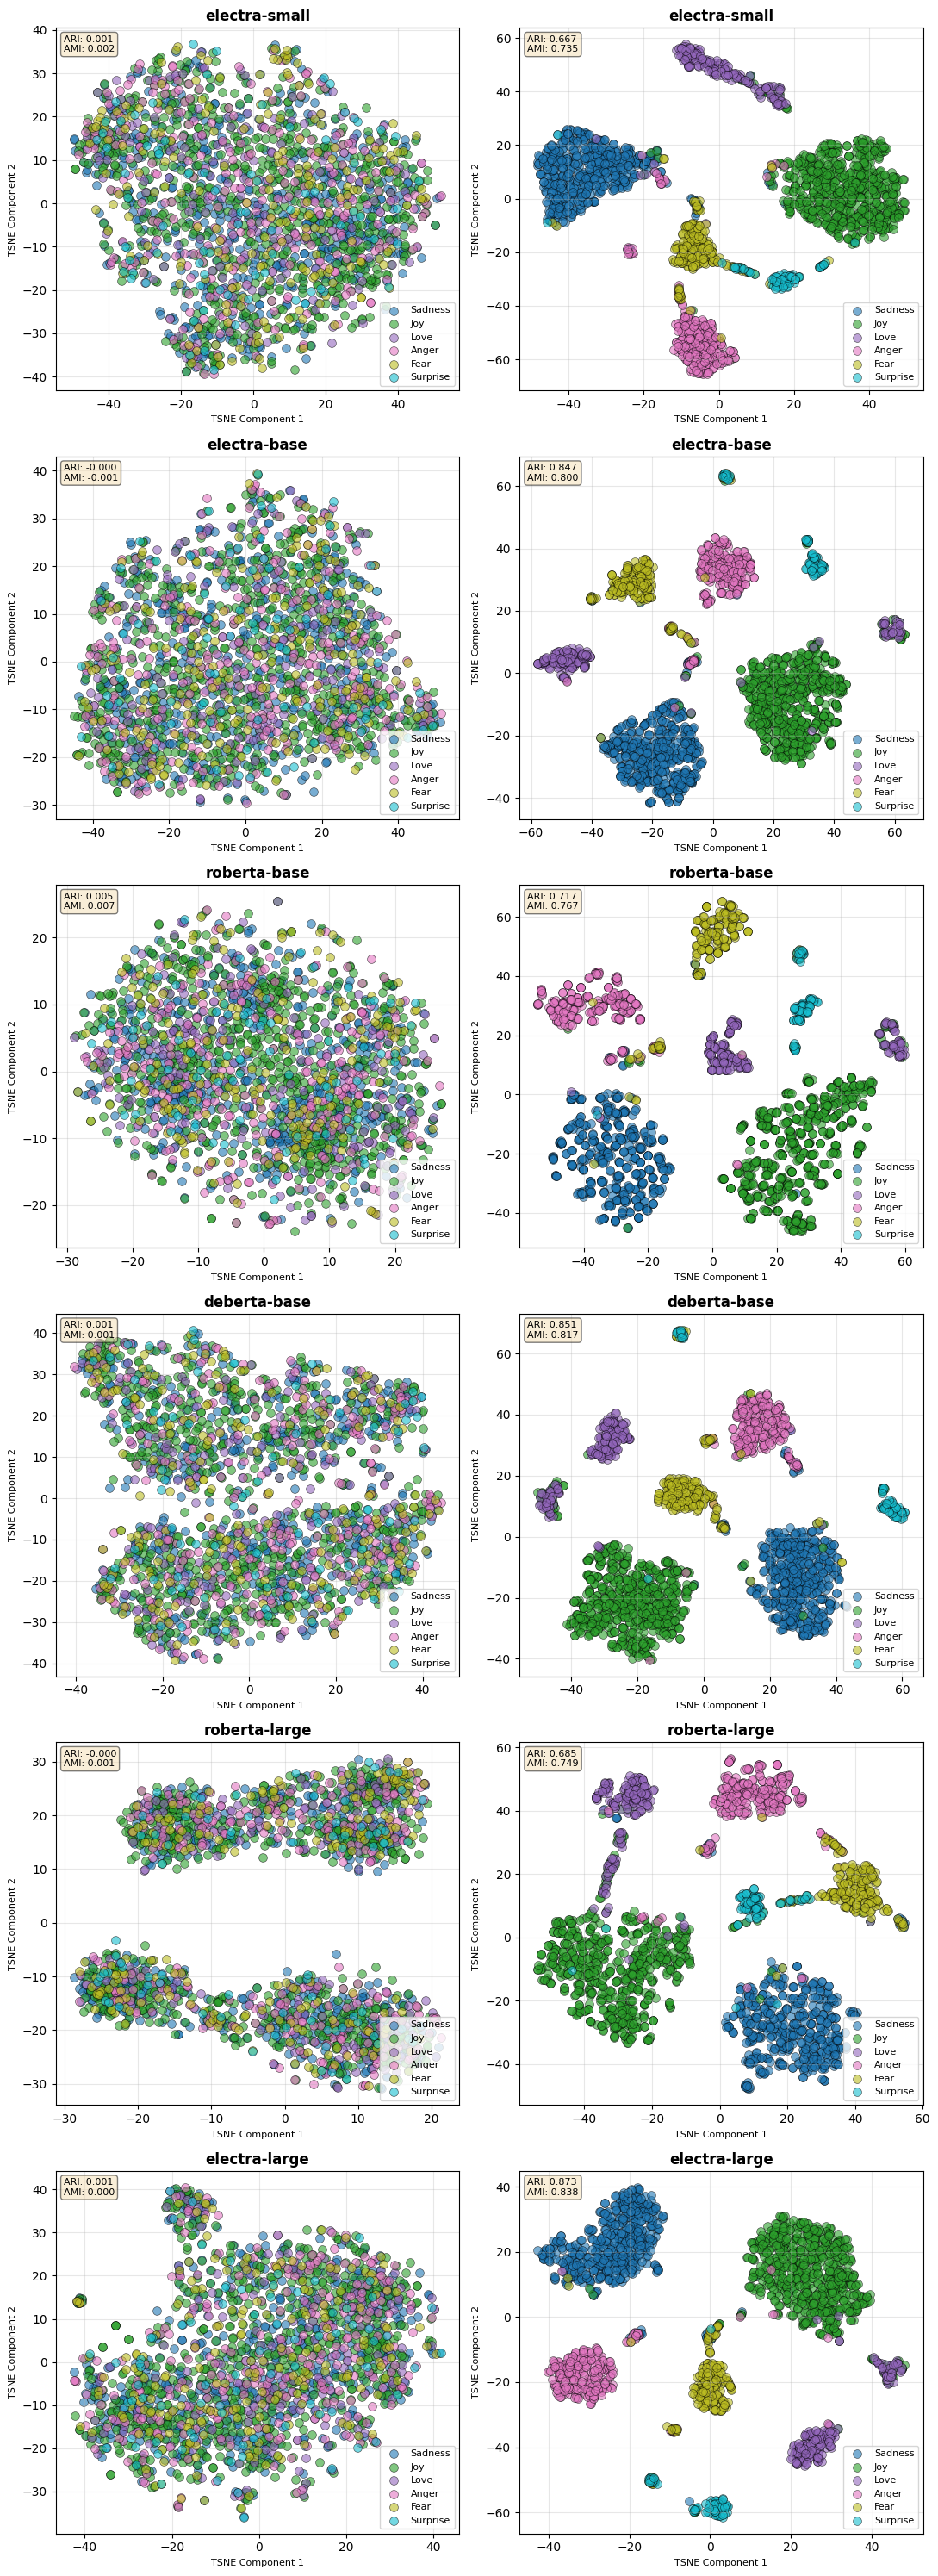

In [39]:
cleaned_dataset = dataset.map(clean_text)
plot_feature_comparison(model_names, trained_models, cleaned_dataset["test"], 
                            label_mapping_path='classes.json', fname="plots/feature_separation", 
                            selected_model="nisimachluf/electra-base-tweet-classification", selected_model_fpath="plots/feature_separation-electra_base",
                            method='tsne', metrics_cache_file="cached_results/feature_separability_metrics.json")

### Compression visualization, Iterative step vs rum time

We present two graphs analyzing iterative compression in terms of predictive performance and inference efficiency. The first graph depicts the trade-off between F1 score and inference latency, illustrating the efficiency frontier achieved across pruning iterations, while the second graph shows F1 retention and relative runtime as a function of the pruning stage. We evaluate two iterative strategies: a progressive teacher–student scheme, where each student becomes the teacher for the next iteration, and a fixed-teacher scheme that uses the original model throughout.

In [98]:
def time_performance_compression1(models, is_step, predict_on_dataset, preprocessed_dataset, **prediction_kwargs):

    
    model_paths = {
        "Full": "nisimachluf/electra-base-tweet-classification"}
#         "step1": step_dir_name + "0",
#         "step2": step_dir_name + "1",
#         "step3": step_dir_name + "2",
#         "step4": step_dir_name + "3",
#         "step5": step_dir_name + "4",
#     }
#     model_paths["step6"] = os.path.join(dir_name, "with_ce") if is_step else os.path.join(dir_name, "ce")
    for i, model in enumerate(models):
        model_paths[f"step{i}"] = model
        
    
    rows = []
    for name, path in model_paths.items():
        print(name, path)
        res = predict_on_dataset(path, preprocessed_dataset, **prediction_kwargs)
        metrics = res["metrics"]
        rows.append({
            "model": name,
            "f1": metrics["f1"],
            "runtime_ms": res["time_per_sample_mean"] * 1000,
        })

    df = pd.DataFrame(rows)
    
    # Calculate Speedup relative to 'Full'
    full_runtime = df.loc[df['model'] == 'Full', 'runtime_ms'].values[0]
    df['speedup'] = full_runtime / df['runtime_ms']

    plt.figure(figsize=(10, 6))
    
    frontier = df.sort_values("runtime_ms")

    # A point is on the frontier if no other point has higher F1 AND lower runtime
    plt.plot(frontier["runtime_ms"], frontier["f1"], 'r--', alpha=0.3, label="Efficiency Frontier")

    for _, row in df.iterrows():
        color = 'black' if row['model'] == 'Full' else '#1f77b4'
        marker = 'D' if row['model'] == 'Full' else 'o'
        
        plt.scatter(row["runtime_ms"], row["f1"], c=color, marker=marker, s=100, edgecolors='white', zorder=5)
        
        label = f"{row['model']}\n({row['speedup']:.2f}x)" if row['model'] != 'Full' else "Full Model"
        plt.annotate(
            label,
            (row["runtime_ms"], row["f1"]),
            xytext=(7, 7),
            textcoords="offset points",
            fontsize=9,
            fontweight='bold' if row['model'] == 'Full' else 'normal'
        )

    plt.xlabel("Inference Time per Sample [ms]", fontsize=12)
    plt.ylabel("F1", fontsize=12)
    plt.title("Compression Efficiency: F1 Score vs. Latency", fontsize=14, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    return df
def iterative_with_trainer_same_teacher(teacher_model, processed_dataset, tokenizer, layers_to_drop, loss, data_collator, save_dir="students_iterative"): 
    """
    Iterative distillation using copy.deepcopy + layer popping with your Trainer class.

    teacher_model: HuggingFace teacher model (frozen)
    train_dataloader, val_dataloader: HuggingFace DataLoaders`
    tokenizer: tokenizer for saving/loading
    layers_to_drop: list of layers to drop in order (top layers first)
    num_epochs_per_student: number of epochs for each student
    save_dir: folder to save each student model
    """
    os.makedirs(save_dir, exist_ok=True)
    teacher = teacher_model
    current_student = copy.deepcopy(teacher)
    for step, layer_idx in enumerate(layers_to_drop):
        print(f"\n--- Iteration {step}/{len(layers_to_drop)} ---")
        print(f"Dropping layer {layer_idx} for this student")

        # student imitate teacher
        student = copy.deepcopy(current_student)

        # Drop the specified layer
        student.electra.encoder.layer.pop(layer_idx)
        student.config.num_hidden_layers -= 1
        for param in student.parameters():
            param.requires_grad = True

        print("Teacher params:", count_parameters(current_student)[0])
        print("Student params:", count_parameters(student)[0])

        if step == len(layers_to_drop) - 1:
            step_save_path = os.path.join(save_dir, f"with_{loss}")
        else:
            step_save_path = os.path.join(save_dir, f"step{step}")

        trainer = CompressionTrainer(
            loss_name=loss,
            teacher=teacher, # Use the model from last step
            student=student,         # new student
            dataset=processed_dataset,
            data_collator=data_collator,
            tokenizer=tokenizer,
            weights=calc_class_weights(processed_dataset['train']),
            path=step_save_path
            )
    
        trainer.inialize_training()

        trainer.early_stop = False 
        
        trainer.train_model()
        
        current_student = copy.deepcopy(trainer.student).cpu().eval()


        print("\nIterative distillation finished!")
        print(f"Final student is saved in: {step_save_path}")
    return step_save_path  # folder of the final student

Loading cached results for electra-base-tweet-classification on test split
Loading cached results for electra-base-pruned-diff-teacher-step0 on test split
Loading cached results for electra-base-pruned-diff-teacher-step1 on test split
Loading cached results for electra-base-pruned-diff-teacher-step2 on test split
Loading cached results for electra-base-pruned-diff-teacher-step3 on test split
Loading cached results for electra-base-pruned-diff-teacher-step4 on test split
Loading cached results for electra-base-pruned-diff-teacher-step5 on test split


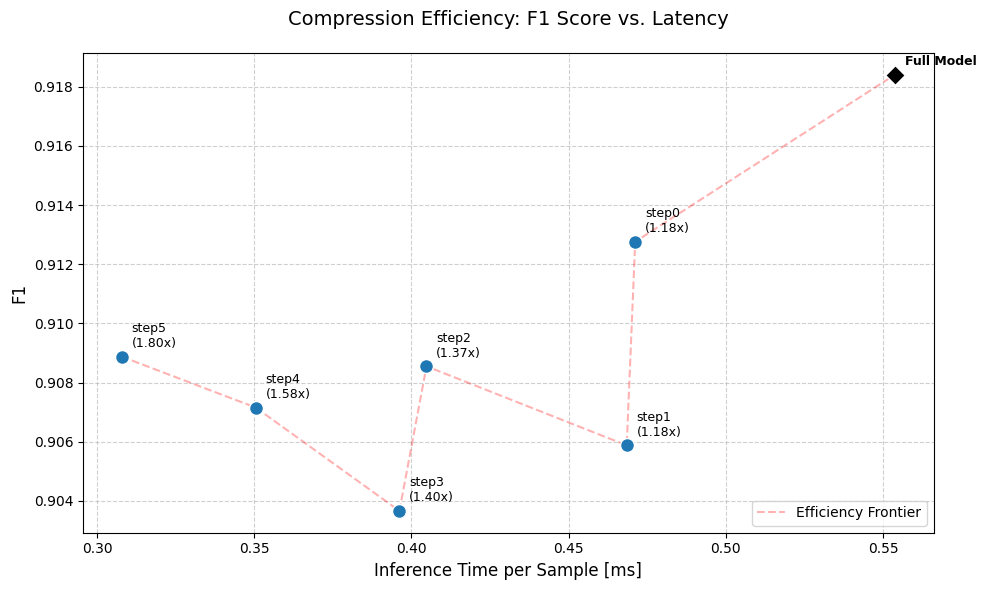

In [85]:
# # This is as we did earlier, in each step, the student become the teacher of the next step
save_dir = "iterative_steps"
local_trained_models = [osp.join(save_dir, f"step{i}") for i in range(5)] + [osp.join(save_dir, "with_ce")]
remote_trained_models = [f"nisimachluf/electra-base-pruned-diff-teacher-step{i}" for i in range(6)]

if not all([model_exists_on_hub(model) for model in remote_trained_models]):
    first_teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
    final_student_folder = iterative_with_trainer(first_teacher, processed_dataset, tokenizer,
                                                        layers_to_drop, "ce", data_collator, save_dir=save_dir)
    for local_trained, remote_trained in zip(local_trained_models, remote_trained_models):
        create_repo(repo_id=remote_trained, repo_type="model", exist_ok=True)
        upload_folder(
            folder_path=local_trained,
            repo_id=remote_trained,
            repo_type="model",
            ignore_patterns=["*.pyc", "__pycache__"]
        )
df = time_performance_compression1(remote_trained_models, True, predict_on_dataset, preprocessed_dataset, cache_file="cached_results/compressed_iterative_predictions.json", name_extension_len=-1)


--- Iteration 0/6 ---
Dropping layer 11 for this student
Teacher params: 109486854
Student params: 102398982
Validation Accuracy: 0.9269
Validation Accuracy: 0.9357
Validation Accuracy: 0.9338
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9385
Validation Accuracy: 0.9373
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9398
Validation Accuracy: 0.9404
Validation Accuracy: 0.9385
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9391
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9382
EarlyStopping counter: 3 out of 3

Iterative distillation finished!
Final student is saved in: iterative_steps_same_teacher/step0

--- Iteration 1/6 ---
Dropping layer 9 for this student
Teacher params: 102398982
Student params: 95311110
Validation Accuracy: 0.9379
Validation Accuracy: 0.9335
EarlyStopping counter: 1 out of 3
Validation Accuracy: 0.9366
EarlyStopping counter: 2 out of 3
Validation Accuracy: 0.9385
Validation Accuracy: 0.9395
Validation Accuracy: 0.9382


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Full nisimachluf/electra-base-tweet-classification
Loading cached results for electra-base-tweet-classification on test split
step0 nisimachluf/electra-base-pruned-same-teacher-step0
Loading model: electra-base-pruned-same-teacher-step0


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 32.17it/s]


Saving results to cached_results/compressed_iterative_predictions.json
step1 nisimachluf/electra-base-pruned-same-teacher-step1
Loading model: electra-base-pruned-same-teacher-step1


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/381M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 34.86it/s]


Saving results to cached_results/compressed_iterative_predictions.json
step2 nisimachluf/electra-base-pruned-same-teacher-step2
Loading model: electra-base-pruned-same-teacher-step2


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 37.85it/s]


Saving results to cached_results/compressed_iterative_predictions.json
step3 nisimachluf/electra-base-pruned-same-teacher-step3
Loading model: electra-base-pruned-same-teacher-step3


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/325M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Saving results to cached_results/compressed_iterative_predictions.json
step4 nisimachluf/electra-base-pruned-same-teacher-step4
Loading model: electra-base-pruned-same-teacher-step4


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/296M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 43.12it/s]


Saving results to cached_results/compressed_iterative_predictions.json
step5 nisimachluf/electra-base-pruned-same-teacher-step5
Loading model: electra-base-pruned-same-teacher-step5


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Inference: 100%|██████████| 63/63 [00:01<00:00, 45.13it/s]


Saving results to cached_results/compressed_iterative_predictions.json


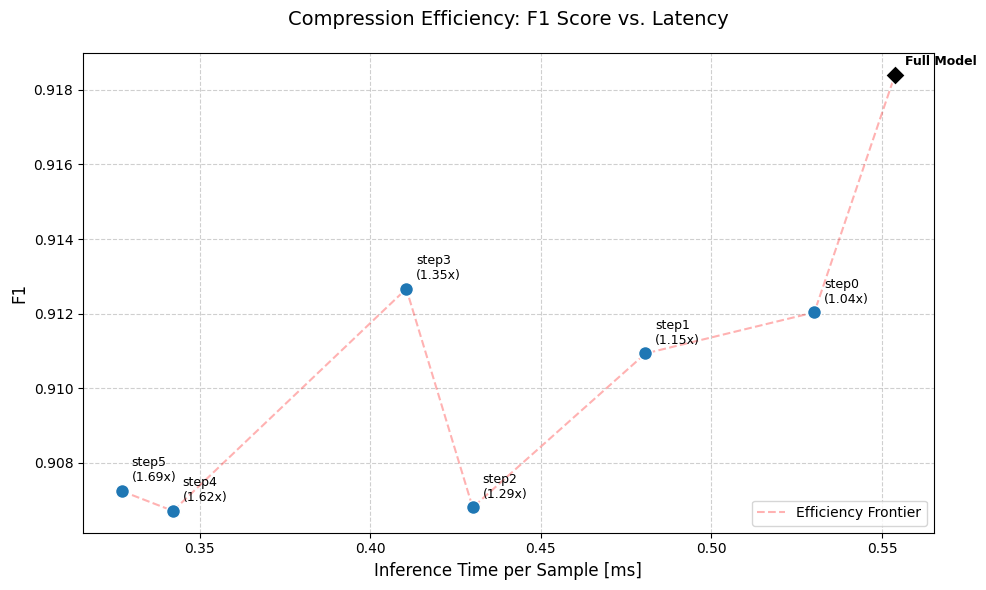

In [99]:
# in this way, the teacher remains the same as the origin electra-base model
save_dir = "iterative_steps_same_teacher"
local_trained_models = [osp.join(save_dir, f"step{i}") for i in range(5)] + [osp.join(save_dir, "with_ce")]
remote_trained_models = [f"nisimachluf/electra-base-pruned-same-teacher-step{i}" for i in range(6)]

if not all([model_exists_on_hub(model) for model in remote_trained_models]):
    first_teacher, tokenizer = load_hf_classifier(model_name, n_classes=6, training=False)
    final_student_folder = iterative_with_trainer_same_teacher(first_teacher, processed_dataset, tokenizer,
                                                        layers_to_drop, "ce", data_collator, save_dir=save_dir)
    for local_trained, remote_trained in zip(local_trained_models, remote_trained_models):
        create_repo(repo_id=remote_trained, repo_type="model", exist_ok=True)
        upload_folder(
            folder_path=local_trained,
            repo_id=remote_trained,
            repo_type="model",
            ignore_patterns=["*.pyc", "__pycache__"],
            commit_message="Upload model files",
            )
            
df_same_teacher = time_performance_compression1(remote_trained_models, True, predict_on_dataset, preprocessed_dataset, cache_file="cached_results/compressed_iterative_predictions.json", name_extension_len=-1)

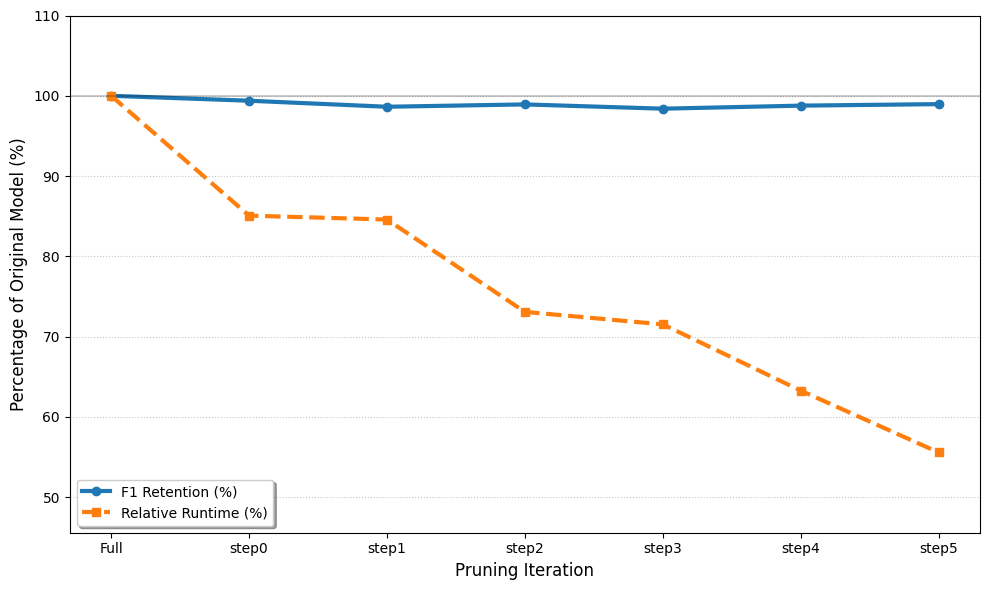

In [100]:
#we chose to show only one of the methods, since both look alike.
plot_percentage_trends(df)

## Prediction function for submission

#### Usage Instructions:

As required by the submission guidelines, we implement an inference function that receives the model weights and a dataset as inputs and outputs the model predictions.
 
The weights of our best-performing model are available at nisimachluf/electra-large-tweet-classificationr.

Function Behavior

The function performs the following steps:

1. Automatically loads and cleans the text data

2. Generates predictions using the specified model

3. Prints evaluation metrics (accuracy, precision, recall, and F1) if ground-truth labels are provided in the CSV file.

4. Returns a list of predicted class indices

The input CSV file must contain at least a text column.
If a label column is included, evaluation metrics will be computed and displayed automatically.

#### Usage Exapmle:

In this example, we:

1. Load our best-performing model from Hugging Face. The access token for the repository ID is provided in the accompanying .env file.

2. Run the inference function on the original validation file, which contains labels, allowing the function to compute and report evaluation metrics.

In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="nisimachluf/electra-large-tweet-classification",
    local_dir="submission/model",
    local_dir_use_symlinks=False
)

In [ ]:
from utils import run_inference

# Run inference on a CSV file
predictions = run_inference(
    weights='submission/model',
    csv='validation.csv'
)

#### Submission:

In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="nisimachluf/electra-large-tweet-classification",
    local_dir="your required target folder path",
    local_dir_use_symlinks=False
)

In [ ]:
from utils import run_inference

# Run inference on a CSV file
predictions = run_inference(
    weights='your required target folder path',
    csv='path to your file we.csv'
)